## Study of the score calibration used by HH-Suite

The neural network calibration used by default in HHsearch/HHblits/HHalign controls how hit score value is converted to the reported $P{\text -}value, E{\text -}value$, and $Probability$ for each reported hit.<br>
In HH-Suite v.2.x there is an option, "-calm" that can switch off this mode, whereas in HH-Suite v.3.x this option was deleted.<br>
See the [User Guide](https://github.com/soedinglab/hh-suite/wiki#dont-i-need-to-calibrate-my-query-or-database-hmm) for brief description of this feature.

In [2]:
import os
import sys
import math
import copy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%pylab inline
# print(numpy.__version__)
# print(matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib


These functions are adapted from HH-Suite 2.0.16 C++ code:

In [3]:
class Hit:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

def CalculatePvalues(h):
    log1000 = math.log(1000.0)
    query_log_len = math.log(h.q_L)/log1000
    hit_log_len = math.log(h.t_L)/log1000
    h.lamda = lamda_NN(query_log_len, hit_log_len, h.q_Neff/10.0, h.t_Neff/10.0)
    h.mu = mu_NN(query_log_len, hit_log_len, h.q_Neff/10.0, h.t_Neff/10.0)
    h.logPval = logPvalue(h.score,h.lamda,h.mu)
    h.Pval = Pvalue(h.score,h.lamda,h.mu)
    h.Eval = math.exp(h.logPval + math.log(h.N_searched))
    h.logEval = h.logPval + math.log(h.N_searched)
    if h.logPval < -10.0:
        x = h.logPval
    else:
        x = math.log(-math.log(1-h.Pval))
    h.score_aass = x/0.45 - min(h.lamda*h.score_ss,max(0.0,0.2*(h.score-8.0)))/0.45 - 3.0
    h.Probab = Probab(-h.score_aass, h.score_ss != 0.0)

def calc_hidden_output(weights, bias, Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Calculate output of hidden neural network units"
    # Calculate activation of hidden unit = sum of all inputs * weights + bias
    res = Lqnorm*weights[0] + Ltnorm*weights[1] + Nqnorm*weights[2] + Ntnorm*weights[3] + bias
    res = 1.0 / (1.0 + math.exp(-(res))) # logistic function
    return res

def lamda_NN(Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Neural network regressions of lamda for EVD"
    inputs = 4
    hidden = 4
    biases = [-0.73195, -1.43792, -1.18839, -3.01141] # bias for all hidden units
    weights = [ # Weights for the neural networks (column = start unit, row = end unit)
    -0.52356, -3.37650, 1.12984, -0.46796,
    -4.71361, 0.14166, 1.66807, 0.16383,
    -0.94895, -1.24358, -1.20293, 0.95434,
    -0.00318, 0.53022, -0.04914, -0.77046,
    2.45630, 3.02905, 2.53803, 2.64379
    ]
    lamda=0.0
    for h in range(hidden):
        lamda += calc_hidden_output(weights[inputs*h:], biases[h], Lqnorm,Ltnorm,Nqnorm,Ntnorm) * weights[hidden*inputs+h]
    return lamda

def mu_NN(Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Neural network regressions of mu for EVD"
    inputs = 4
    hidden = 6
    biases = [-4.25264, -3.63484, -5.86653, -4.78472, -2.76356, -2.21580]  # bias for all hidden units
    weights = [ # Weights for the neural networks (column = start unit, row = end unit)
    1.96172, 1.07181, -7.41256, 0.26471,
    0.84643, 1.46777, -1.04800, -0.51425,
    1.42697, 1.99927, 0.64647, 0.27834,
    1.34216, 1.64064, 0.35538, -8.08311,
    2.30046, 1.31700, -0.46435, -0.46803,
    0.90090, -3.53067, 0.59212, 1.47503,
    -1.26036, 1.52812, 1.58413, -1.90409, 0.92803, -0.66871
    ]
    mu=0.0
    for h in range(hidden):
        mu += calc_hidden_output(weights[inputs*h:], biases[h], Lqnorm,Ltnorm,Nqnorm,Ntnorm) * weights[hidden*inputs+h]
    return 20.0*mu

def Pvalue(x, lamda, mu):
    h = lamda*(x-mu)
    if h > 10:
        return math.exp(-h)
    else:
        return 1.0 - math.exp(-math.exp(-h))

def logPvalue(x, lamda, mu):
    h = lamda*(x-mu)
    if h > 10:
        return -h
    else:
        if h < -2.5:
            return -math.exp(-math.exp(-h))
        else:
            return math.log((1.0 - math.exp(-math.exp(-h))))

def Probab(s, has_ss):
    """
    Calculate probability of true positive : p_TP(score)/( p_TP(score)+p_FP(score) )
    TP: same superfamily OR MAXSUB score >=0.1
    """
    if s > 200:
        return 100.0
    if has_ss:
        # local with SS
        a=math.sqrt(6000.0)
        b=2.0*2.5
        c=math.sqrt(0.12)
        d=2.0*32.0
    else:
        # local no SS
        a=math.sqrt(4000.0)
        b=2.0*2.5
        c=math.sqrt(0.15)
        d=2.0*34.0
    t = a*math.exp(-s/b) + c*math.exp(-s/d)
    return 100.0/(1.0+t*t) # ??? JS Jul'12

Hit data from HHsearch results (profile's Neff can be found in the header of HMM file)

In [8]:
# BHJJX25971_pp1ab_1-7195 vs. PF06471.9 hit
hit0 = Hit(score=69.407066, score_ss=0, q_Neff=1.0, t_Neff=2.7, q_L=7195, t_L=584, N_searched=1,
    Probab_HH=91.42, Pval_HH=8.9388e-7)

# IHH test case with nearly maximum Probability gain:
# NP_690588.1_1-2474 vs. PF01728.18 (iteration_1)
hit1 = Hit(score=40.7270432, score_ss=-0.0733758, q_Neff=1.0, t_Neff=11.7, q_L=2474, t_L=183, N_searched=1,
    Probab_HH=77.7733154, Pval_HH=1.50802e-05)
# NP_690588.1_1166-1348 vs. PF01728.18 (iteration_2)
hit2 = Hit(score=39.3617821, score_ss=-0.0733758, q_Neff=1.0, t_Neff=11.7, q_L=(1348-1166+1), t_L=183, N_searched=1,
    Probab_HH=95.1556091, Pval_HH=1.15029e-07)

# IHH test case with nearly minimum Probability gain:
# YP_007438864.1_1-7391 vs. PF14314.5 (iteration_1)
hit3 = Hit(score=60.8448601, score_ss=9.9903307, q_Neff=1.0, t_Neff=8.3, q_L=7391, t_L=691, N_searched=1,
    Probab_HH=92.5439987, Pval_HH=1.014336e-05)
# YP_007438864.1_4398-6376 vs. PF14314.5 (iteration_2)
hit4 = Hit(score=61.2097855, score_ss=9.9903307, q_Neff=1.0, t_Neff=8.3, q_L=(6376-4398+1), t_L=691, N_searched=1,
    Probab_HH=95.4742966, Pval_HH=1.472818e-06)

# test for v.3.1, FIXME delete it
# hit2v3 = Hit(score=39.3652458, score_ss=-0.0733756, q_Neff=1.0, t_Neff=11.7, q_L=(1348-1166+1), t_L=183, N_searched=1,
#    Probab_HH=94.1558990, Pval_HH=1.148324e-07)


# feel free to choose another hit
hit = hit4

CalculatePvalues(hit)

print('HHsearch Probability:', hit.Probab_HH)
print('HHsearch P-value:', hit.Pval_HH)

# FIXME delete it
# print('Calculated logPval:', hit.logPval)
# print('Calculated score_aass:', hit.score_aass)

print('Calculated Probability:', hit.Probab)
print('Calculated P-value:', hit.Pval)

HHsearch Probability: 95.4742966
HHsearch P-value: 1.472818e-06
Calculated Probability: 95.47429035906627
Calculated P-value: 1.4728221431647446e-06


## Plots for P-value and Probabilities

Thus the results correspond to the reported by HHsearch $P{\text -}, E{\text -}value$ and $Probability$ values.

Now plot the graphs in order to study how the calibration affects the reported values depending on the query / target HMM lengths.

In [9]:
def getPvalueLen(q_len, t_len):
    h.q_L = q_len
    h.t_L = t_len
    CalculatePvalues(h)
    return h.Pval

def getProbabLen(q_len, t_len):
    h.q_L = q_len
    h.t_L = t_len
    CalculatePvalues(h)
    return h.Probab

def getPvalueNeff(q_Neff, t_Neff):
    h.q_Neff = q_Neff
    h.t_Neff = t_Neff
    CalculatePvalues(h)
    return h.Pval

def getProbabNeff(q_Neff, t_Neff):
    h.q_Neff = q_Neff
    h.t_Neff = t_Neff
    CalculatePvalues(h)
    return h.Probab

q_len_log = np.linspace(1, 10, 30)
t_len_log = np.linspace(1, 10, 30)
X,Y = np.meshgrid(np.exp(q_len_log), np.exp(t_len_log))

def testLengths(Z, func):
    for i, logx in enumerate(q_len_log):
        for j, logy in enumerate(t_len_log):
            x, y = math.exp(logx), math.exp(logy)
            Z[i, j] = func(x, y)

h = cp.copy(hit)

Pval = X.copy()
testLengths(Pval, getPvalueLen)

Prob = X.copy()
testLengths(Prob, getProbabLen)

### P-value as a function of query / target lengths

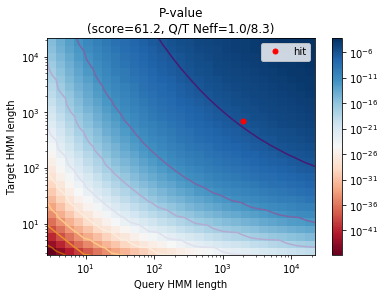

In [10]:
fig, ax = plt.subplots()
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
sc = math.floor(h.score * 10) / 10
ax.set_title('P-value\n(score=' + str(sc) + ', Q/T Neff=' + str(h.q_Neff) + '/' + str(h.t_Neff)+ ')')
ax.set_xlabel('Query HMM length')
ax.set_ylabel('Target HMM length')

p = ax.pcolor(X, Y, Pval, cmap=cm.RdBu, norm=LogNorm(vmin=Pval.min(), vmax=Pval.max()))
ax.contour(X, Y, Pval, cmap=cm.PuOr, norm=LogNorm(vmin=Pval.min(), vmax=Pval.max()))
ax.plot([hit.q_L], [hit.t_L], marker='o', linestyle=' ', markersize=5, color='red', label='hit')
ax.legend()
cb = fig.colorbar(p)

### Probability as a function of query / target lengths

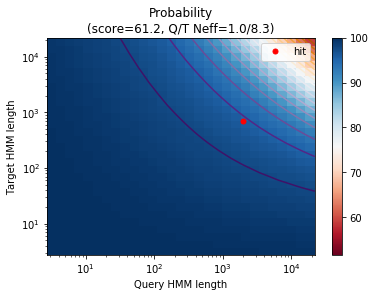

In [11]:
fig, ax = plt.subplots()
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
ax.set_title('Probability\n(score=' + str(sc) + ', Q/T Neff=' + str(h.q_Neff) + '/' + str(h.t_Neff)+ ')')
ax.set_xlabel('Query HMM length')
ax.set_ylabel('Target HMM length')

p = ax.pcolor(X, Y, Prob, cmap=cm.RdBu, vmin=Prob.min(), vmax=100)
ax.contour(X, Y, Prob, 20, cmap=cm.PuOr)
ax.plot([hit.q_L], [hit.t_L], marker='o', linestyle=' ', markersize=5, color='red', label='hit')
ax.legend()

cb = fig.colorbar(p)

In [12]:
q_neff = np.linspace(1, 20, 40)
t_neff = np.linspace(1, 20, 40)
X,Y = np.meshgrid(q_neff, t_neff)

def testNeff(Z, func):
    for i, x in enumerate(q_neff):
        for j, y in enumerate(t_neff):
            Z[i, j] = func(x, y)

h = cp.copy(hit)

Pval = X.copy()
testNeff(Pval, getPvalueNeff)

Prob = X.copy()
testNeff(Prob, getProbabNeff)

### P-value as a function of query / target diversities

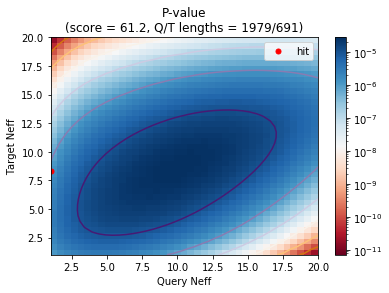

In [13]:
fig, ax = plt.subplots()
ax.set_title('P-value\n(score = ' + str(sc) + ', Q/T lengths = ' + str(h.q_L) + '/' + str(h.t_L) + ')')
ax.set_xlabel('Query Neff')
ax.set_ylabel('Target Neff')

p = ax.pcolor(X, Y, Pval, cmap=cm.RdBu, norm=LogNorm(vmin=Pval.min(), vmax=Pval.max()))
ax.contour(X, Y, Pval, cmap=cm.PuOr, norm=LogNorm(vmin=Pval.min(), vmax=Pval.max()))
ax.plot([hit.q_Neff], [hit.t_Neff], marker='o', linestyle=' ', markersize=5, color='red', label='hit')
ax.legend()
cb = fig.colorbar(p)

### Probability as a function of query / target diversities

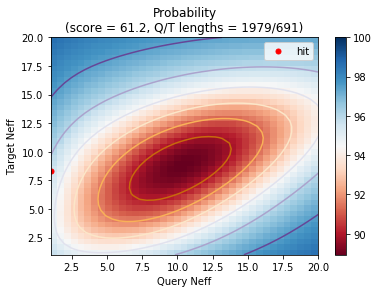

In [14]:
fig, ax = plt.subplots()
ax.set_title('Probability\n(score = ' + str(sc) + ', Q/T lengths = ' + str(h.q_L) + '/' + str(h.t_L) + ')')
ax.set_xlabel('Query Neff')
ax.set_ylabel('Target Neff')

p = ax.pcolor(X, Y, Prob, cmap=cm.RdBu, vmin=Prob.min(), vmax=100)
ax.contour(X, Y, Prob, cmap=cm.PuOr)
ax.plot([hit.q_Neff], [hit.t_Neff], marker='o', linestyle=' ', markersize=5, color='red', label='hit')
ax.legend()
cb = fig.colorbar(p)

In [15]:
q_len_log = np.linspace(1, 10, 30)
X = np.exp(q_len_log)

h = cp.copy(hit)

n_len = 300
n_Neff = 1

def resetHit(norm):
    global h
    h = cp.copy(hit)
    if norm:
        h.t_L = h.q_L = n_len
        h.q_Neff = h.t_Neff = n_Neff

def getEvalueQLen(q_len):
    h.q_L = q_len
    CalculatePvalues(h)
    return h.Pval

def getEvalueTLen(t_len):
    h.t_L = t_len
    CalculatePvalues(h)
    return h.Pval

def testLengths(Z, func, norm):
    for i, logx in enumerate(q_len_log):
        x = math.exp(logx)
        resetHit(norm)
        Z[i] = func(x)

### P-value as function of query/target lengths, again

For BLAST hits estimated E-value is proportional to both query and database lengths.<br>
In HHsearch $E{\text -}value = P{\text -}value * N$, where $N$ &mdash; number of entries in the searched database.<br>
And apparently, for HHsearch $P{\text -}value$ is not proportional to neither query or target lengths, see below.

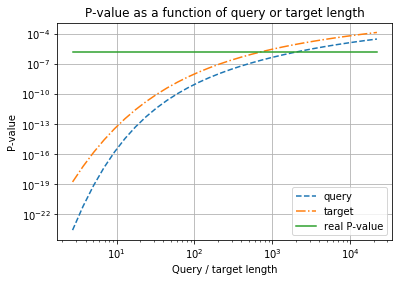

In [16]:
fig, ax = plt.subplots()

QPval = X.copy()
testLengths(QPval, getEvalueQLen, False)

TPval = X.copy()
testLengths(TPval, getEvalueTLen, False)

ax.loglog(X, QPval, linestyle='--', label='query')
ax.loglog(X, TPval, linestyle='-.', label='target')
ax.plot(X, [hit.Pval] * len(X), '-', label='real P-value')
ax.legend()
ax.grid(True)
ax.set_title('P-value as a function of query or target length')
ax.set_xlabel('Query / target length')
ax.set_ylabel('P-value');

The P-value becomes proportional to the query length only for very large lengths, ~10000 - 100000.<br>
For the queries of size about 50-500 it's rather $P{\text -}value \propto L^3$

### Check if EVD parameters estimation is symmetric relative to query/target lengths

Suppose that query and target lengths for the hit were equal, how then would $P{\text -}value$ depend on query/target lengths if we pretend it varies?

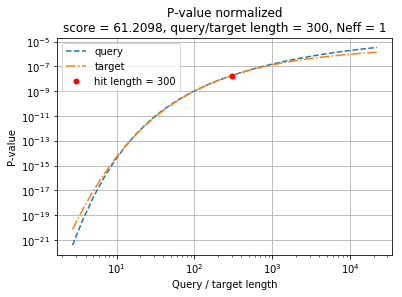

In [17]:
fig, ax = plt.subplots()

QPval = X.copy()
testLengths(QPval, getEvalueQLen, True)

TPval = X.copy()
testLengths(TPval, getEvalueTLen, True)

ax.loglog(X, QPval, linestyle='--', label='query')
ax.loglog(X, TPval, linestyle='-.', label='target')

resetHit(True)
CalculatePvalues(h)
ax.plot([n_len], [h.Pval], marker='o', linestyle=' ', markersize=5, color='red', label=('hit length = %d'  % n_len))

ax.legend()
ax.grid(True)
ax.set_title('P-value normalized\nscore = %7.4f, query/target length = %d, Neff = %d' % (hit.score, n_len, n_Neff))
ax.set_xlabel('Query / target length')
ax.set_ylabel('P-value');

The graphs are indistinguishable in the range of 10&ndash;1000 therefore EVD parameters are almost symmetric to query vs. target lengths.<br>